In [1]:
import tensorflow as tf

import tensorflow.compat.v1 as tf1
import numpy as np 

import logging
import sys

In [2]:
import logging

logger = logging.getLogger()
handler = logging.StreamHandler(sys.stderr)
handler.setFormatter(logging.Formatter('%(name)s:%(levelname)s:%(message)s'))
logger.handlers = [handler]

## Specify Model parameters

In [33]:
# Specify a model that was previously trained 
# by transfer_learning_and_test.ipynb

# Hyperparameters
ALPHA = 0.35
MOBILENET_V = 2
IMAGE_SIDE = 128
INPUT_SHAPE = (IMAGE_SIDE, IMAGE_SIDE, 3)
IMAGE_SHAPE = (IMAGE_SIDE, IMAGE_SIDE)
BATCH_INPUT_SHAPE = (1,)+INPUT_SHAPE
CLASSES = 2
# Training timestamp
timestamp = "1606938572" # v2 0.35

## Import model

In [34]:
alpha_string = str(ALPHA).replace('.','')
model_name = "mobilenet_v{}_{}_{}".format(MOBILENET_V, alpha_string, IMAGE_SIDE)

model_path = './saved_models/retrained_{}_{}'.format(model_name, timestamp) # 
model_float = tf.keras.models.load_model(model_path)

model_float.build(INPUT_SHAPE)

model_float.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_0.35_128 (Functi (None, 4, 4, 1280)        410208    
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 412,770
Trainable params: 398,690
Non-trainable params: 14,080
_________________________________________________________________


## Get test data

In [35]:
batch_size = 100
data_dir = "./test_images"
image_test_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=False,
  label_mode='categorical',
  image_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
  batch_size=batch_size)

classes = image_test_data.class_names
print("classes: "+str(classes))

Found 32 files belonging to 2 classes.
classes: ['hotdogs', 'not_hotdogs']


In [36]:
def rescale(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

image_test_data = image_test_data.map(rescale)

## Evaluate the model

In [37]:
model_float.evaluate(image_test_data)

1/1 [==============================] - 0s 7ms/step - loss: 0.2019 - accuracy: 0.8750


[0.20194333791732788, 0.875]

## Quantize the float32 model

In [38]:
print(tf.executing_eagerly())
for images, labels in image_test_data.take(1):
   images = images

True


In [39]:
from tflite2xcore.utils import quantize_keras_model

logger.setLevel(logging.INFO)
model_quant = quantize_keras_model(
    model_float,
    representative_data=images,
    show_progress_step=10
)
print(type(model_quant))

INFO:tensorflow:Assets written to: /var/folders/81/fvtc03bn6mvc1c5f801qly7m0000gp/T/tmp1ltj26iy/assets


tensorflow:INFO:Assets written to: /var/folders/81/fvtc03bn6mvc1c5f801qly7m0000gp/T/tmp1ltj26iy/assets
root:INFO:Converter quantization processed examples     10/32
root:INFO:Converter quantization processed examples     20/32
root:INFO:Converter quantization processed examples     30/32


<class 'bytes'>


In [40]:
#save quantized model
model_quant_path = './quantized_models/{}_model_quant.tflite'.format(model_name)
with open(model_quant_path, "wb") as f:
    s = f.write(model_quant)
print("Wrote {}".format(model_quant_path))

Wrote ./quantized_models/mobilenet_v2_035_128_model_quant.tflite


## Optimize and convert for xcore.ai

In [41]:
logger.setLevel(logging.ERROR)

from tflite2xcore.converter import convert as convert_to_xcore

model_xcore_path = "./quantized_models/{}_model_xcore.tflite".format(model_name)

convert_to_xcore(model_quant_path, model_xcore_path)

# Test and compare the models

In [20]:
def get_prediction_idx_and_score(prediction, output_quantization=None):
    from tflite2xcore.utils import dequantize   
    prediction = np.squeeze(prediction) # Remove lower dimensions of size 1 to turn last dimension into 1-D array
    if output_quantization!=None:
        prediction = dequantize(prediction, *output_quantization)
    pred_idx = prediction.argmax()
    pred_score = prediction[pred_idx]
    return prediction, pred_idx, pred_score


In [21]:
def add_misprediction(mispredictions, model_name, image_index, image, class_name):
    # use uniqe image index as key
    if image_index not in mispredictions:
        mispredictions[image_index] = {} 
        mispredictions[image_index]['image'] = image
        mispredictions[image_index]['class_name'] = class_name
        mispredictions[image_index]['models'] = [] # list of models that mispredicted this image
    mispredictions[image_index]['models'].append(model_name)


In [22]:
from tflite2xcore.utils import (
    apply_interpreter_to_examples  # sets input tensors, invokes the interpreter, retrieves outputs
)
from xcore_interpreters import XCOREInterpreter

float_predictions = []
quant_predictions = []
xcore_predictions = []
groundtruths = []

mispredictions = {}

interpreter_quant = tf.lite.Interpreter(model_content=model_quant)
input_quant = interpreter_quant.get_input_details()[0]["quantization"]
output_quant = interpreter_quant.get_output_details()[0]["quantization"]
print(input_quant)

#interpreter_xcore = XCOREInterpreter(model_path=model_xcore_path)
with XCOREInterpreter(model_path=model_xcore_path) as interpreter_xcore:
    input_quant_xcore = interpreter_xcore.get_input_details()[0]["quantization"]
    output_quant_xcore = interpreter_xcore.get_output_details()[0]["quantization"]
    
    # run inference on the examples
    for images, labels in image_test_data:
        for i, image in enumerate(images):
            print("testing image "+str(i))
            batch_image = tf.reshape(image, BATCH_INPUT_SHAPE)
            pred_float = model_float.predict(batch_image)
            pred_float, pred_idx_float, pred_score_float = get_prediction_idx_and_score(pred_float)
            float_predictions.append(pred_idx_float)
            
            # convert to int8 for quantized model
            batch_image =  tf.image.convert_image_dtype(batch_image, tf.int8)        
            
            # quantized model
            pred_quant = apply_interpreter_to_examples(interpreter_quant, batch_image)
            pred_quant, pred_idx_quant, pred_score_quant = get_prediction_idx_and_score(pred_quant, output_quantization=output_quant)
            quant_predictions.append(pred_idx_quant)
            # quantized xcore model
            #quant_image = quantize(batch_image, *input_quant_xcore)
            quant_image = batch_image
            pred_xcore = apply_interpreter_to_examples(interpreter_xcore, quant_image)
            pred_xcore, pred_idx_xcore, pred_score_xcore = get_prediction_idx_and_score(pred_xcore, output_quantization=output_quant_xcore)        
            xcore_predictions.append(pred_idx_xcore)
    
            #print(pred_idx)
            label_idx = tf.argmax(labels[i], axis=-1)
            groundtruths.append(label_idx)
            if(label_idx != pred_idx_float):
                print("Error in float model: label: "+classes[label_idx]+", prediction: "+classes[pred_idx_float])
                add_misprediction(mispredictions, 'float model', i, image, classes[label_idx])
            if(label_idx != pred_idx_quant):
                print("Error quantized model: label: "+classes[label_idx]+", prediction: "+classes[pred_idx_quant])
                add_misprediction(mispredictions, 'quantized model', i, image, classes[label_idx])
            if(label_idx != pred_idx_xcore):
                print("Error xcore model: label: "+classes[label_idx]+", prediction: "+classes[pred_idx_xcore])
                add_misprediction(mispredictions, 'xcore model', i, image, classes[label_idx])
    
            #if(pred_idx_quant!=pred_idx_float):
            #    print("Warning: quantized model prediction: "+classes[pred_idx_quant]+", does not match float model prediction : "+classes[pred_idx_float])        
       

(0.003921568859368563, -128)
testing image 0
Error quantized model: label: hotdogs, prediction: not_hotdogs
Error xcore model: label: hotdogs, prediction: not_hotdogs
testing image 1
Error in float model: label: hotdogs, prediction: not_hotdogs
Error quantized model: label: hotdogs, prediction: not_hotdogs
Error xcore model: label: hotdogs, prediction: not_hotdogs
testing image 2
Error quantized model: label: hotdogs, prediction: not_hotdogs
Error xcore model: label: hotdogs, prediction: not_hotdogs
testing image 3
Error quantized model: label: hotdogs, prediction: not_hotdogs
Error xcore model: label: hotdogs, prediction: not_hotdogs
testing image 4
testing image 5
testing image 6
Error quantized model: label: hotdogs, prediction: not_hotdogs
Error xcore model: label: hotdogs, prediction: not_hotdogs
testing image 7
testing image 8
Error quantized model: label: hotdogs, prediction: not_hotdogs
Error xcore model: label: hotdogs, prediction: not_hotdogs
testing image 9
testing image 10


In [23]:
# Compute accuracy for each model
groundtruths_array = np.asarray(groundtruths)
num_images = len(groundtruths)
float_correct = np.sum(groundtruths_array== np.asarray(float_predictions))
float_acc = float_correct/num_images
print(float_acc)

quant_correct = np.sum(groundtruths_array== np.asarray(quant_predictions))
quant_acc = quant_correct/num_images
print(quant_acc)

xcore_correct = np.sum(groundtruths_array== np.asarray(xcore_predictions))
xcore_acc = xcore_correct/num_images
print(xcore_acc)





0.875
0.8125
0.8125


## Print confusion matrix for all models

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
#import pandas as pd
#import seaborn as sn
print("Confusion matrix C showing true and false predictions for all models. C[0:0] = true hotdog, C[0:1] false hotdog, C[1:0] false not hotdog, C[1:1] true not hotdog")

print("Confusion matrix for float model")
print(confusion_matrix(groundtruths, float_predictions))

print("Confusion matrix for quantized model")
print(confusion_matrix(groundtruths, quant_predictions))

print("Confusion matrix for xcore model")
mat = confusion_matrix(groundtruths, xcore_predictions)
print(mat)

#plt.matshow(mat)

Confusion matrix C showing true and false predictions for all models. C[0:0] = true hotdog, C[0:1] false hotdog, C[1:0] false not hotdog, C[1:1] true not hotdog
Confusion matrix for float model
[[ 8  1]
 [ 3 20]]
Confusion matrix for quantized model
[[ 3  6]
 [ 0 23]]
Confusion matrix for xcore model
[[ 3  6]
 [ 0 23]]


## Plot mispredicted images

In [25]:
from matplotlib import pyplot as plt
def plot_mispredictions():
    num_mispred = len(mispredictions)
    plt.figure(figsize=(16, 14*(num_mispred+13)/14))

    for j, image_index in enumerate(mispredictions):
        mp = mispredictions[image_index]
        plt.subplot((num_mispred+2)/3, 3, j + 1)
        plt.imshow(mispredictions[image_index]['image'])
        plt.title('\n'.join(["ground truth: {} mispredicted by:".format(mp["class_name"])] + [model for model in mp['models']]))

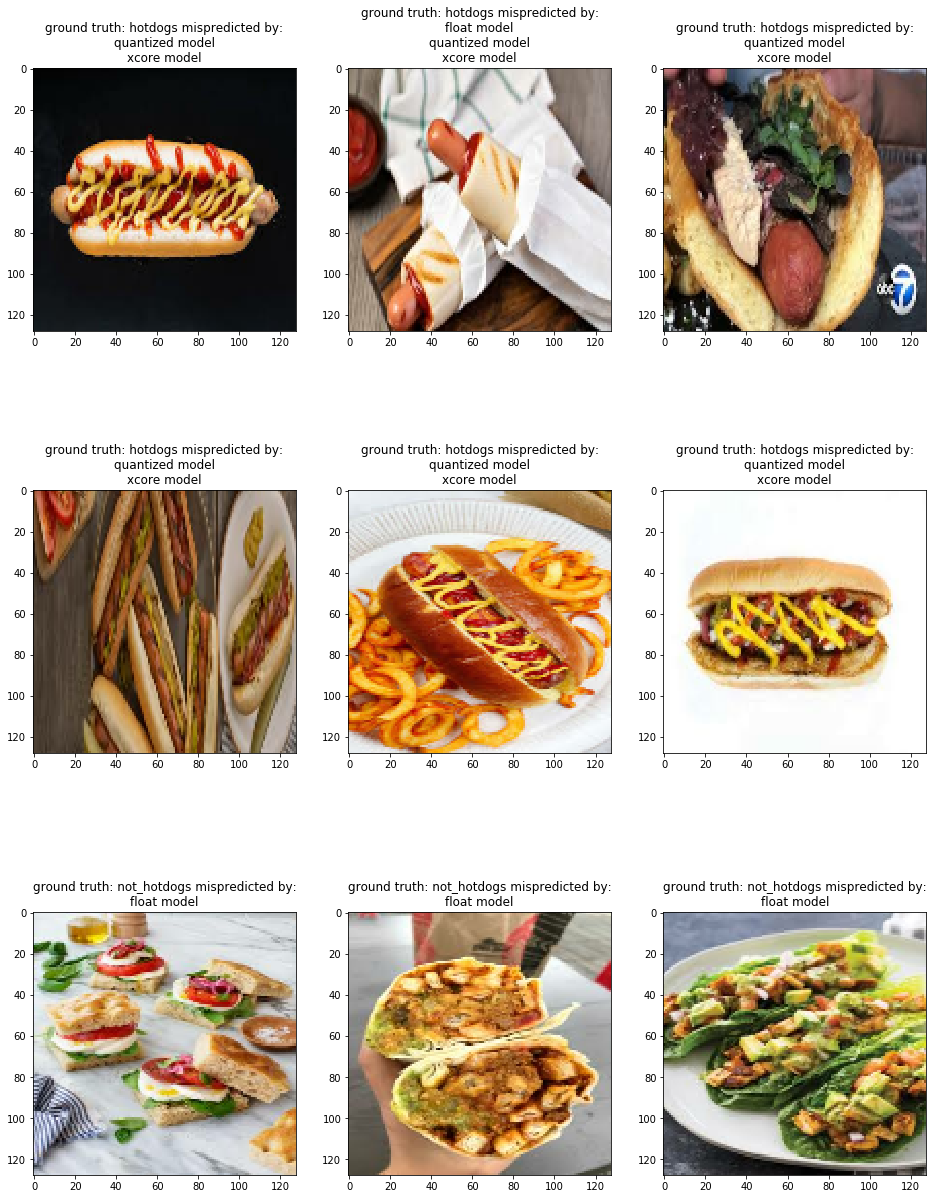

In [26]:
plot_mispredictions()

# Visualise the model

In [27]:
from tflite2xcore import tflite_visualize

model_xcore_html = "./quantized_models/{}_model_xcore.html".format(model_name)

# Open model_xcore.html manually
tflite_visualize.main(model_xcore_path, model_xcore_html)

In [28]:
def update_xlsx_file(xlsx_file, df):
    import pandas as pd
    import os
    # Create or update the xlsx_file
    writer = pd.ExcelWriter(xlsx_file, engine='openpyxl')
    
    if(os.path.exists(xlsx_file)):
        # try to open an existing workbook
        print("Appending to existing file {}".format(xlsx_file))
        header = False
        writer.book = load_workbook(xlsx_file)
    else:
        print("Creating new file {}".format(xlsx_file))
        header = True
    # copy existing sheets
    writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
    num_rows = 0
    if(os.path.exists(xlsx_file)):
        # read existing file
        reader = pd.read_excel(r'{}'.format(xlsx_file))
        num_rows = len(reader)
    # write out the new sheet
    df.to_excel(writer,index=False,header=header,startrow=num_rows+1)
    
    writer.close()

In [29]:
import pandas as pd
from openpyxl import load_workbook

xlsx_file = 'compare_float_and_quantized_models.xlsx'
   
# new dataframe with same columns
df = pd.DataFrame(
                  {
                   'net_name': ["mobilenet_v{}".format(MOBILENET_V)],
                   'alpha': [ALPHA],
                   'num params' : [model_float.count_params()],
                   'input shape': [str(INPUT_SHAPE)],
                   'float accuracy': [float_acc],
                   'quant accuracy': [quant_acc],
                   'xcore accuracy': [xcore_acc],
                   'timestamp' : [timestamp],
                  }
                 )

update_xlsx_file(xlsx_file, df)



Appending to existing file compare_float_and_quantized_models.xlsx
